In [1]:
import numpy as np

data = np.genfromtxt("RPCL01RPTrain.csv",delimiter=',')
dataDev = np.genfromtxt("RPCL01RPTrainDev.csv",delimiter=',')

Test = np.genfromtxt("RPCL01RPTest.csv",delimiter=',')
Dev = np.genfromtxt("RPCL01RPDev.csv",delimiter=',')

print(np.shape(data))
print(np.shape(dataDev))
print(np.shape(Test))
print(np.shape(Dev))

(12000, 13856)
(566, 13856)
(570, 13856)
(2000, 13856)


In [2]:
from __future__ import with_statement
from __future__ import division
from __future__ import absolute_import
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

n_hidden = 256

def PlaceH(n_input): 
    x = tf.placeholder(u"float", [None, n_input])
    y_ = tf.placeholder(u"float", [None,n_input])
    return x, y_

def corruption(input, corruption_level): #corruption of the input
    mask=np.random.binomial(1, 1 - corruption_level,input.shape ) #mask with several zeros at certain position
    corrupted_input=input*mask
    return corrupted_input

def Initializarion(n_input, n_hidden, n_samp):
    Wh = tf.Variable(tf.random_uniform((n_input, n_hidden), -4.0* math.sqrt(6/(n_input+n_samp)), 
                                        4.0* math.sqrt(6/(n_samp+n_input))))
    bh = tf.Variable(tf.zeros([n_hidden]))     
    Wo = tf.transpose(Wh) # tied weights
    bo = tf.Variable(tf.zeros([n_input]))
    return Wh, bh, Wo, bo

def AE(dat, Wh, Wo, bh, bo):     
    h = tf.nn.sigmoid(tf.matmul(dat,Wh) + bh)
    ho = tf.nn.sigmoid(tf.matmul(h, Wo) + bo)
    return h,ho

def KF(dat, k):
    kf = KFold(n_splits=k)
    kf.get_n_splits(dat)
    return kf.split(dat)

def compute_cost(Z, y_):
    logits = Z
    labels = y_    
    cost = tf.reduce_mean(tf.losses.mean_squared_error (predictions = logits , labels = labels))    
    return cost

def random_mini_batches(X, Y, mini_batch_size = 10, seed = 42):    
    np.random.seed(seed)            
    m = X.shape[0]                  
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X
    shuffled_Y = Y

    num_complete_minibatches = math.floor(m/mini_batch_size)
    
    #print(type(num_complete_minibatches))
    
    for k in xrange(0, int(num_complete_minibatches)):
        mini_batch_X = shuffled_X[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    Lower = num_complete_minibatches * mini_batch_size
    Upper = m - (mini_batch_size * math.floor(m/mini_batch_size))
    if m % mini_batch_size != 0:
        mini_batch_X = X[Lower : Lower + Upper, :]
        mini_batch_Y = Y[Lower : Lower + Upper, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches, permutation

def model(X_train, Y_train, X_test, Y_test, X_Test, Y_Test, learning_rate = 0.01,
          num_epochs = 10, minibatch_size = 10, print_cost = True):
    seed = 0 
    tf.set_random_seed(seed)    
    (n_samp, n_input) = X_train.shape                         
    costs = []                                        
    
    X, Y = PlaceH(n_input)

    Wh, bh, Wo, bo = Initializarion(n_input, n_hidden, n_samp)
    
    H, Z = AE(X, Wh, Wo, bh, bo)
    
    cost = compute_cost(Z, Y)
    optimizer = tf.train.AdagradOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in xrange(num_epochs):

            epoch_cost = 0.                     
            num_minibatches = int(n_samp / minibatch_size) 
            seed = seed + 1
            minibatches, permutation = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost = epoch_cost + (minibatch_cost / num_minibatches)

            print u"Cost after epoch %i: %f" % (epoch, epoch_cost)
            costs.append(np.mean(epoch_cost))
                
        plt.plot(np.squeeze(costs))
        plt.ylabel(u'cost')
        plt.xlabel(u'iterations (per tens)')
        plt.title(u"Learning rate =" + unicode(learning_rate))
        plt.show()
        
        Weight = sess.run(Wh, feed_dict={X: X_train, Y: Y_train})
        bias = sess.run(bh, feed_dict={X: X_train, Y: Y_train})
        Hidden = sess.run(H, feed_dict={X: X_train, Y: Y_train})
        Y_hat = sess.run(Z, feed_dict={X: X_train, Y: Y_train})
        ts_cost = cost.eval({X: X_test, Y: Y_test})
        Ts_cost = cost.eval({X: X_Test, Y: Y_Test})
        print u"Dev cost:", ts_cost  
        print u"Test cost:", Ts_cost  
        print u"Parameters have been trained!"
        return Weight, bias, Hidden, Y_hat, costs, ts_cost, Ts_cost 


Cost after epoch 0: 0.036919
Cost after epoch 1: 0.034840
Cost after epoch 2: 0.034143
Cost after epoch 3: 0.033209
Cost after epoch 4: 0.031935
Cost after epoch 5: 0.030348
Cost after epoch 6: 0.028593
Cost after epoch 7: 0.026862
Cost after epoch 8: 0.025302
Cost after epoch 9: 0.023984
Cost after epoch 10: 0.022914
Cost after epoch 11: 0.022063
Cost after epoch 12: 0.021392
Cost after epoch 13: 0.020863
Cost after epoch 14: 0.020442
Cost after epoch 15: 0.020104
Cost after epoch 16: 0.019828
Cost after epoch 17: 0.019600
Cost after epoch 18: 0.019407
Cost after epoch 19: 0.019243
Cost after epoch 20: 0.019099
Cost after epoch 21: 0.018973
Cost after epoch 22: 0.018860
Cost after epoch 23: 0.018757
Cost after epoch 24: 0.018662
Cost after epoch 25: 0.018574
Cost after epoch 26: 0.018492
Cost after epoch 27: 0.018413
Cost after epoch 28: 0.018338
Cost after epoch 29: 0.018266
Cost after epoch 30: 0.018196
Cost after epoch 31: 0.018128
Cost after epoch 32: 0.018061
Cost after epoch 33:

Cost after epoch 268: 0.011290
Cost after epoch 269: 0.011276
Cost after epoch 270: 0.011262
Cost after epoch 271: 0.011249
Cost after epoch 272: 0.011236
Cost after epoch 273: 0.011222
Cost after epoch 274: 0.011209
Cost after epoch 275: 0.011196
Cost after epoch 276: 0.011182
Cost after epoch 277: 0.011169
Cost after epoch 278: 0.011156
Cost after epoch 279: 0.011143
Cost after epoch 280: 0.011130
Cost after epoch 281: 0.011117
Cost after epoch 282: 0.011104
Cost after epoch 283: 0.011092
Cost after epoch 284: 0.011079
Cost after epoch 285: 0.011066
Cost after epoch 286: 0.011053
Cost after epoch 287: 0.011041
Cost after epoch 288: 0.011028
Cost after epoch 289: 0.011016
Cost after epoch 290: 0.011003
Cost after epoch 291: 0.010991
Cost after epoch 292: 0.010978
Cost after epoch 293: 0.010966
Cost after epoch 294: 0.010954
Cost after epoch 295: 0.010941
Cost after epoch 296: 0.010929
Cost after epoch 297: 0.010917
Cost after epoch 298: 0.010905
Cost after epoch 299: 0.010893
Cost aft

Cost after epoch 533: 0.008974
Cost after epoch 534: 0.008969
Cost after epoch 535: 0.008963
Cost after epoch 536: 0.008958
Cost after epoch 537: 0.008953
Cost after epoch 538: 0.008947
Cost after epoch 539: 0.008942
Cost after epoch 540: 0.008936
Cost after epoch 541: 0.008931
Cost after epoch 542: 0.008926
Cost after epoch 543: 0.008920
Cost after epoch 544: 0.008915
Cost after epoch 545: 0.008910
Cost after epoch 546: 0.008904
Cost after epoch 547: 0.008899
Cost after epoch 548: 0.008894
Cost after epoch 549: 0.008889
Cost after epoch 550: 0.008883
Cost after epoch 551: 0.008878
Cost after epoch 552: 0.008873
Cost after epoch 553: 0.008868
Cost after epoch 554: 0.008863
Cost after epoch 555: 0.008857
Cost after epoch 556: 0.008852
Cost after epoch 557: 0.008847
Cost after epoch 558: 0.008842
Cost after epoch 559: 0.008837
Cost after epoch 560: 0.008832
Cost after epoch 561: 0.008827
Cost after epoch 562: 0.008822
Cost after epoch 563: 0.008817
Cost after epoch 564: 0.008812
Cost aft

Cost after epoch 798: 0.007942
Cost after epoch 799: 0.007939
Cost after epoch 800: 0.007936
Cost after epoch 801: 0.007933
Cost after epoch 802: 0.007931
Cost after epoch 803: 0.007928
Cost after epoch 804: 0.007925
Cost after epoch 805: 0.007923
Cost after epoch 806: 0.007920
Cost after epoch 807: 0.007917
Cost after epoch 808: 0.007915
Cost after epoch 809: 0.007912
Cost after epoch 810: 0.007910
Cost after epoch 811: 0.007907
Cost after epoch 812: 0.007904
Cost after epoch 813: 0.007902
Cost after epoch 814: 0.007899
Cost after epoch 815: 0.007897
Cost after epoch 816: 0.007894
Cost after epoch 817: 0.007891
Cost after epoch 818: 0.007889
Cost after epoch 819: 0.007886
Cost after epoch 820: 0.007884
Cost after epoch 821: 0.007881
Cost after epoch 822: 0.007879
Cost after epoch 823: 0.007876
Cost after epoch 824: 0.007874
Cost after epoch 825: 0.007871
Cost after epoch 826: 0.007869
Cost after epoch 827: 0.007866
Cost after epoch 828: 0.007863
Cost after epoch 829: 0.007861
Cost aft

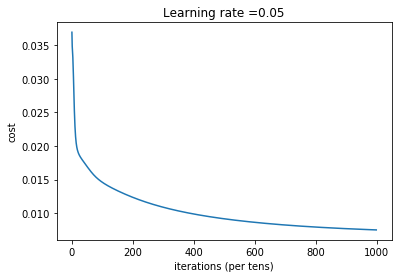

Dev cost: 0.0080753
Test cost: 0.0080753
Parameters have been trained!
Two Files are saved!
Files are saved!


In [4]:
#from IPython import get_ipython
#get_ipython().magic('reset -sf')

import numpy as np
#import DAE 


n_hidden = 256
corruption_level = 0.2
n_fold = 10
final_train_cost = []
final_test_cost = []
final_params = []
final_permutations = []

#data = np.genfromtxt("FilterRPTrain.csv",delimiter=',')
#Dev = np.genfromtxt("FilterRPDev.csv",delimiter=',')

output_data = data
input_data = corruption(data, corruption_level)


n_samp, n_input = input_data.shape 

folds = KF(input_data, n_fold)

u"""
for tr, ts in folds: 
     parameters, tr_costs, ts_costs, permutation = DAE.model(input_data[tr, :], output_data[tr, :], input_data [ts, :], 
                                                            output_data[ts, :],  learning_rate = 0.01, 
                                                            num_epochs = 35, minibatch_size = 10,)
     final_params.append(parameters)
     final_train_cost.append(tr_costs)
     final_test_cost.append(ts_costs)
     final_permutations.append(permutation)
"""

from __future__ import absolute_import
Weight, bias, Hidden, Y_hat, tr_costs, ts_costs, Ts_cost = model(input_data, output_data, Dev, 
                                                            Dev, Test, Test, learning_rate = 0.05, 
                                                            num_epochs = 1000, minibatch_size = 10)
#final_params.append(parameters)
#final_train_cost.append(tr_costs)
#final_test_cost.append(ts_costs)
#final_permutations.append(permutation)




#np.savetxt('W.csv', Weight, fmt = '%.3f', delimiter = u',')
#np.savetxt('Activations.csv', Hidden, fmt = '%.7f', delimiter = u',')
print "Two Files are saved!"

#np.savetxt('Prediction.csv', Y_hat, fmt = '%.7f', delimiter = u',')

#np.savetxt('perm.txt', final_permutations, fmt = '%.7f', delimiter=',')

print "Files are saved!"




In [5]:
print u"Test cost:", Ts_cost

Test cost: 0.00799443
